# Crop image crops from high resolution tissue image using the ImageContainer
spatial tools provides an `ImageContainer` class that wraps `Xarray` to store several images in the same coordinate system. It allows lazy loading and has functions for cropping smaller crops from the image. 

In this notebook we will use the ImageContainer to generate crops centered on visium spots.


In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import spatial_tools as st

## Load data

In [1]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla")
adata, img = st.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


img is an ImageContainer object, containing a .data attr which is an xarray

In [2]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 3, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint8 129 129 129 129 128 ... 130 130 133 131 128

## Extract crops using `img.crop_generator`
We can crop a series of images using the `crop_generator`. This generates crops that are centered on the visium spots defined in `adata`. For each spot it returns `(obs_id, crop)`.
Per default, the crop has the size of the spot diameter.

In [3]:
crop_iter = img.crop_spot_generator(adata)
obs_id, crop = next(crop_iter)
print(obs_id, crop.shape)

AAACAAGTATCTCCCA-1 (3, 90, 90)


Lets plot the location of the obs that we have just cropped

In [ ]:
x , y = adata[obs_id].obsm['spatial'][0]
print(x, y)
plt.scatter(x, y, c='green')
plt.imshow(img.data['image'].transpose('y', 'x', ...).data)

### Extract crops with more context
Use the `size` argument to extract crops with a larger neighbourhood.
Note that the function will add `cval` (0 by default) when the range is outside the image.

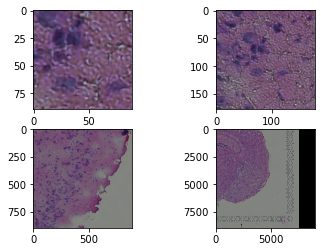

In [7]:
fig, axes = plt.subplots(2,2)
for ax, size in zip(axes.flat, [1,2,10,100]):
    obs_id, crop = next(img.crop_spot_generator(adata, size=size, cval=0))
    ax.imshow(crop.transpose('y','x',...).data)

### Extract crops with different scales
We can downscale the extracted crops using the `scale` argument.

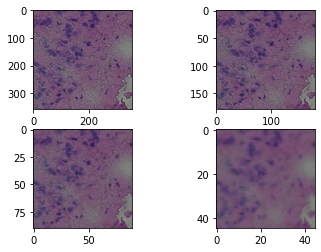

In [9]:
fig, axes = plt.subplots(2,2)
for ax, scale in zip(axes.flat, [1,0.5,0.25,0.125]):
    obs_id, crop = next(img.crop_spot_generator(adata, size=4, scale=scale))
    ax.imshow(crop.transpose('y','x',...).data)

### Mask crops with circle
In order to make sure that features are only calculated on the tissue which was under the visium spot, use the `mask_circle` argument. This can also be combined with different `size`s and `scale`s.

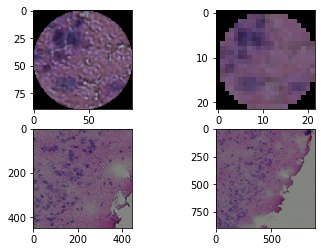

In [10]:
_, crop_1 = next(img.crop_spot_generator(adata, size=1, scale=1, mask_circle=True))
_, crop_2 = next(img.crop_spot_generator(adata, size=1, scale=0.25, mask_circle=True))
_, crop_3 = next(img.crop_spot_generator(adata, size=5, scale=1))
_, crop_4 = next(img.crop_spot_generator(adata, size=10, scale=1))

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1.transpose('y','x',...).data)
axes[0][1].imshow(crop_2.transpose('y','x',...).data)
axes[1][0].imshow(crop_3.transpose('y','x',...).data)
axes[1][1].imshow(crop_4.transpose('y','x',...).data)


# Extract crops using a fluorescence dataset

In [12]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla")
adata, img = st.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Multi-page tiff images with 1 channel (like this fluorescence tiff) are automatically merged in one data array. Cropping will return each fluoresecent image as a channel

In [14]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 3, x: 24240, y: 24240)
Coordinates:
  * channels  (channels) int64 1 1 1
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint16 1644 1616 1628 1628 1664 ... 0 0 0 0 0

When cropping, we need to manually set the dtype to be uint8 to allow plotting with matplotlib

(3, 178, 178) uint8


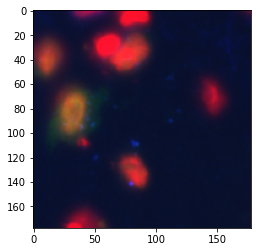

In [16]:
obs_id, crop = next(img.crop_spot_generator(adata, dtype='uint8'))
print(crop.shape, crop.dtype)
plt.imshow(crop.transpose('y','x',...).data)

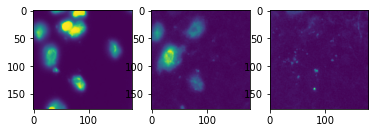

In [20]:
fig, axes = plt.subplots(1,3)
for i, ax in enumerate(axes.flat):
    ax.imshow(crop[i])